In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [2]:
import torch
import multiprocessing
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl

import os
import numpy as np
import matplotlib.pyplot as plt
from blending.utils.dataset import ImageDataBlending, SegmentationData
from blending.utils.image import (get_grabcut, _pil_image, get_bbInfo_from_mask, get_image_laplacian_operator, unormalize_image, _numpy,
                                  get_blending_gradients, get_mixing_gradients,
                                  normalize_image, resize_pad_image, resize_up)
from blending.utils.plots import (plots_multiple_image_data, plots_multiple_tensor_image,
                                  plots_multiple_segmentation_data)
from blending.segmentation import (Predictor, SegmentationModule, VGGFCN)
from blending.models import VGG16_Model, MeanShift

from argparse import Namespace
from tqdm.auto import tqdm
from IPython.display import Image

In [3]:
# os.environ['KMP_DUPLICATE_LIB_OK'] = "TRUE"

In [4]:
opt = Namespace(
    requires_grad_backbone = False,
    #source_dir = 'source_data',
    source_dir_training = '../../data_segmentation/JPEGImages',
    mask_dir_training = '../../data_segmentation/SegmentationObject',
    source_dir = 'source_data',
    target_dir = 'target_data',
    blending_dir = 'blending_data',
    model_dir = 'models',
    normalize = False,
    requires_grad = True,
    device = 'cuda',
    image_index = 1,
)

device = torch.device(opt.device)
image_index = opt.image_index
# source_dir = os.path.join(os.getcwd(), opt.source_dir)
# target_dir = os.path.join(os.getcwd(), opt.target_dir)
# blending_dir = os.path.join(os.getcwd(), opt.blending_dir)
source_dir_training = opt.source_dir_training
mask_dir_training = opt.mask_dir_training
target_dir = opt.target_dir
blending_dir = opt.blending_dir
source_dir = opt.source_dir

# Preprocess for training from cvat

In [5]:
# full_mask_dir = [mask_dir_training+"/"+path for path in os.listdir(mask_dir_training)]
# new_full_mask_dir = [mask_dir_training+"/mask_"+str(int(path.split("/")[-1].split(".")[0]))+"."+path.split("/")[-1].split(".")[1]
#                      for path in full_mask_dir]
# full_source_dir = [source_dir_training+"/"+path for path in os.listdir(source_dir_training)]
# new_full_source_dir = [source_dir_training+"/source_"+str(int(path.split("/")[-1].split(".")[0]))+"."+path.split("/")[-1].split(".")[1]
#                      for path in full_source_dir]
# # Rename files
# for src, dst in zip(full_mask_dir, new_full_mask_dir):
#     os.rename(src, dst)
# for src, dst in zip(full_source_dir, new_full_source_dir):
#     os.rename(src, dst)

# Mask Training

In [6]:
# image_data_segmentation = SegmentationData(image_dir=source_dir_training,
#                                            mask_dir=mask_dir_training,
#                                            preprocess=True)
# modelPytorch = VGGFCN(requires_grad_backbone = opt.requires_grad_backbone,
#                       backbone=16)
# loss = nn.BCEWithLogitsLoss()
# modelLightning = SegmentationModule(modelPytorch, loss)

# if opt.device == "cuda":
#     trainer = pl.Trainer(gpus=torch.cuda.device_count(), num_nodes=1, max_epochs=150)
# else:
#     trainer = pl.Trainer(gpus=0, num_nodes=1, max_epochs=150)
    
# train_dataset, val_dataset = random_split(image_data_segmentation, [int(len(image_data_segmentation)*0.7), 
#                                                         len(image_data_segmentation) - int(len(image_data_segmentation)*0.7)])
# train_dataloader = DataLoader(train_dataset, batch_size=8, 
#                               shuffle=True, num_workers=0)
# val_dataloader = DataLoader(val_dataset, batch_size=4,
#                            shuffle=False,  num_workers=0)

# trainer.fit(modelLightning, train_dataloader, val_dataloader)

# modelPytorch.eval()
# torch.save(modelPytorch, "models/model_segmentation.pt")

# Mask Prediction

In [7]:
# Predictor.set_config(opt.model_dir)
# with resize
image_data_segmentation = SegmentationData(image_dir=source_dir,
                                              preprocess=True)
image_data_ = SegmentationData(image_dir=source_dir,
                                              preprocess=False)
# plots_multiple_segmentation_data(*[image_data_segmentation[i] for i in range(len(image_data_segmentation))])

In [8]:
model = torch.load(opt.model_dir + "/model_segmentation.pt")
model.eval()
mask_ = []
original_ = []
source_ = []
for data in image_data_segmentation:
    # mask_.append(Predictor.predict(data['source'].unsqueeze(0)))
    with torch.no_grad():
        mask = model(data['source'].unsqueeze(0)).sigmoid()
    mask[mask > 0.8] = 1
    mask = mask.round()
    mask_.append(mask.squeeze(0))
    original_.append(data['original_shape'])
    source_.append(data['source'])

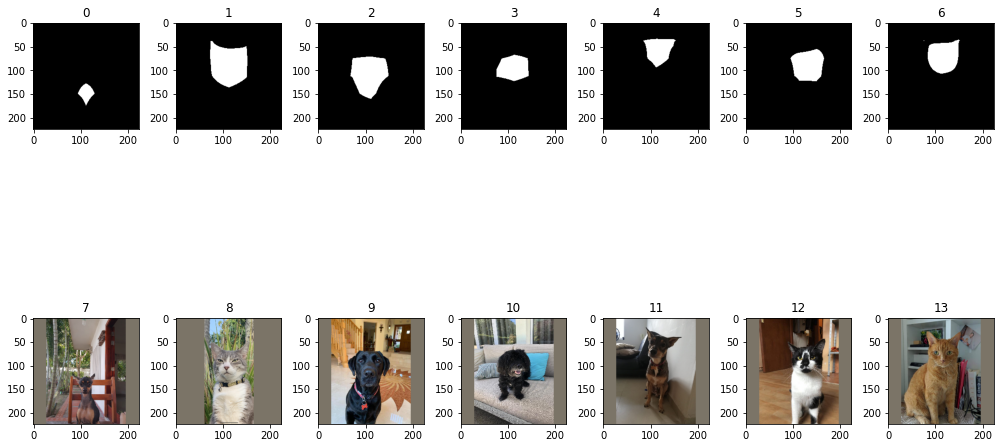

In [9]:
plots_multiple_tensor_image(*mask_, *[unormalize_image(source)*255.0 for source in source_], normalize=opt.normalize, ncols=len(image_data_segmentation))

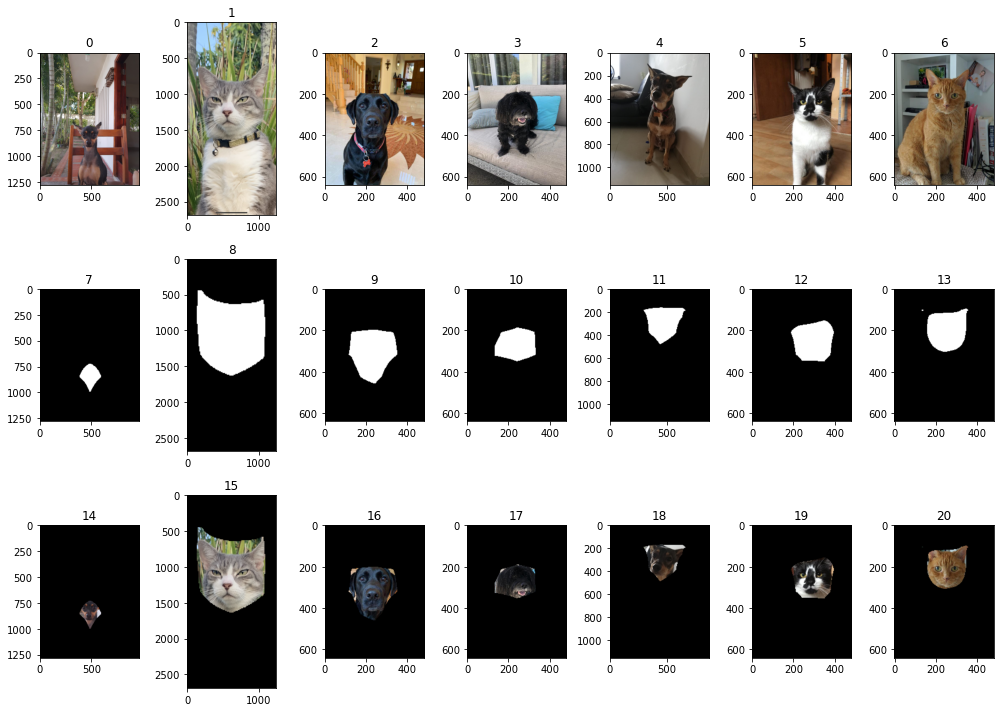

In [10]:
n_mask = [resize_up(mask_[i], down_shape=(224, 224), up_shape=original_[i]) for i in range(len(image_data_segmentation))]
plots_multiple_tensor_image(*[image_data_[i]['source'] for i in range(len(image_data_segmentation))],
                            *n_mask, *[n_mask[i]*image_data_[i]['source'] for i in range(len(image_data_segmentation))],
                            normalize=opt.normalize, ncols=len(image_data_segmentation))

In [29]:
source = _numpy(image_data_[image_index]['source'])
mask =_numpy(n_mask[image_index])
sm_coords, _ = get_bbInfo_from_mask(source=source, mask=mask)
mask_ = get_grabcut(source=source, mask=mask, rect=sm_coords)

In [31]:
_pil_image(mask_).save("mask_grabcut.jpg")

In [17]:
# save images results
for i in range(len(image_data_segmentation)):
    _pil_image(n_mask[i]).save(opt.source_dir+f"/mask_{i+1}.jpg")

## Load Data Segmentation

# Prepare Data for blending alg

In [18]:
image_data_blending = ImageDataBlending(blending_dir, source_dir=opt.source_dir,
                                        target_dir=opt.target_dir, device=device)
# image_data_blending = ImageDataBlending(blending_dir, device=device)

Getting Files:   0%|          | 0/20 [00:00<?, ?it/s]

preprocess data:   0%|          | 0/7 [00:00<?, ?it/s]

Getting Files:   0%|          | 0/16 [00:00<?, ?it/s]

# Load Data

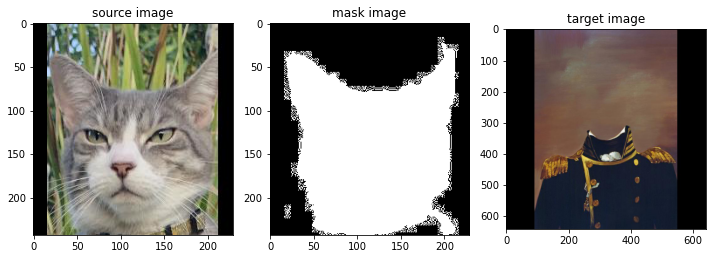

In [19]:
plots_multiple_image_data(image_data_blending[image_index], normalize=opt.normalize)

# Laplacian Operator

Laplacian operator $\nabla I$ over the image:

$$
\nabla = \begin{bmatrix}
     0 & -1 & 0 \\
     -1 & 4 & -1 \\
     0 & -1 & 0
\end{bmatrix}
$$

In order to get the gradients of the images, we are going to define a convolutinal operation using the `laplacian matrix` as the kernel. Then make a convolution between the image, $I$, and the kernel $\nabla$

$$\begin{bmatrix}
     0 & -1 & 0 \\
     -1 & 4 & -1 \\
     0 & -1 & 0
\end{bmatrix} \circledast I$$

The following code will calculate each channel's gradients, and present it as plots 

## Gradients of source image

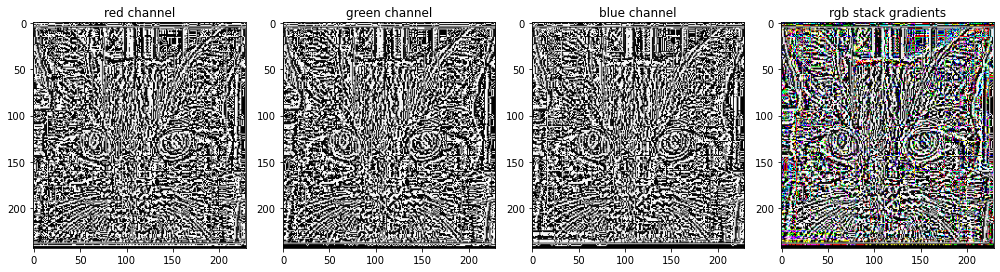

In [14]:
# Show each channel gradient
rgb_gradients_list = get_image_laplacian_operator(image_data_blending[image_index]['source'].unsqueeze(0), device=device)
rgb_gradients = torch.stack(rgb_gradients_list, dim=2).view(*image_data_blending[image_index]['source'].shape)
plots_multiple_tensor_image(*rgb_gradients_list, np.asarray(_pil_image(rgb_gradients)),
                            title_name=["red channel", "green channel", "blue channel", "rgb stack gradients"],
                           normalize=opt.normalize)

## Gradients of target image

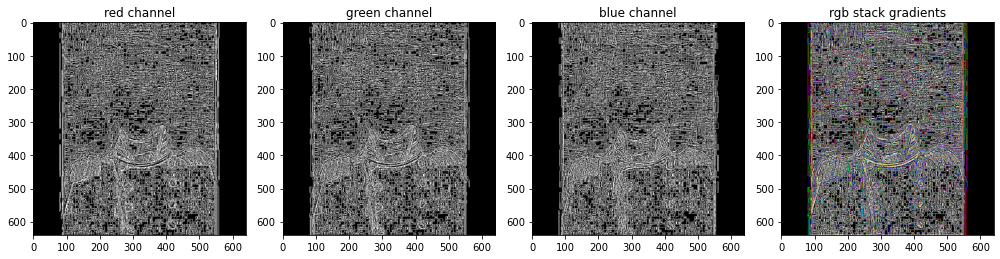

In [15]:
# Show each channel gradient
rgb_gradients_list = get_image_laplacian_operator(image_data_blending[image_index]['target'].unsqueeze(0), device=device)
rgb_gradients = torch.stack(rgb_gradients_list, dim=2).view(*image_data_blending[image_index]['target'].shape)
plots_multiple_tensor_image(*rgb_gradients_list, np.asarray(_pil_image(rgb_gradients)),
                            title_name=["red channel", "green channel", "blue channel", "rgb stack gradients"],
                            normalize=opt.normalize)

# Join Gradients

As we are going to blend both images `source` and `target`, we need to mix its gradients in order to optimize the following loss function:

$$L_{grad} = \frac{1}{2HW} \sum_{m=1}^{H}\sum_{n=1}^{W}[\nabla f(I_B) - (\nabla f(I_S) + \nabla f(I_T)]^{2}_{mn}$$

where $f$ is the blending function, $\nabla$ the laplacian operator, $I_S$ the source image and $I_T$ the target image. This loss function is over the gradients that means we are going to create a image such that optimize the previous loss grad

## Content loss function

For this content loss function we are going to use pretrained model VGG on imagenet, and this is define as:

$$L_{cont} = \sum_{l=1}^{L}\frac{\alpha_l}{2N_lM_l}\sum_{i=1}^{N_l}\sum_{k=1}^{M_l}(F_l[I_{Z} \odot M ] - F_l[I_{S} \odot M ])^{2}_{ik}$$

where $I_Z$ is the random Image that we are going to optimize, and $I_S$ is the source image. But the only layer we are going to use is the second activation layer before `MaxPool2d`

## TV (total variation) loss

The total variation (tv) loss is used to remove the un-wanted details while preserving the import information in the image. The loss objective is shown below.

$$L_{tv} = \sum_{m=1}^{H}\sum_{n=1}^{W}(|I_{m+1,n}-I_{m,n}| + |I_{m,n+1}-I_{m,n}|)$$

where $I$ is the blend image.

In the original implementation they use `MeanShift` module but with some experiments I see that normalizing using imagenet stats give better solutions

In [16]:
# torch.cuda.empty_cache()

image_data = {
    'source': image_data_blending[image_index]['source'].unsqueeze(0)/255.0,
    'target': image_data_blending[image_index]['target'].unsqueeze(0)/255.0,
    'dims': image_data_blending[image_index]['dims'],
    'mask': image_data_blending[image_index]['mask'].unsqueeze(0)
}


target = image_data['target']
h, w = target.shape[2], target.shape[3]
dims = image_data['dims']
x0, y0, x1, y1 = dims

source = torch.zeros_like(target)
source[:, :, y0:y1, x0:x1] = image_data['source']

mask = torch.zeros(1, 1, h, w, device=device)
mask[:,:, y0:y1, x0:x1] = image_data['mask']

del image_data
# torch.cuda.empty_cache()

input_img = torch.randn(*source.shape, device=device).contiguous()
input_img.requires_grad = opt.requires_grad

# tensor_image_target = target.clone()
blend_img = (input_img * mask + target * (1 - mask))
naive_copy = (source * mask + target * (1 - mask))

new_image_data = {
    "mask": mask,
    "target": target,
    "source": source,
    "dims": dims
}

# gt gradients
gt_gradients = torch.stack(get_mixing_gradients(new_image_data, device=device), dim=2).squeeze(0)
vgg16_features = VGG16_Model().to(device=device)
mean_shift = MeanShift().to(device=device)

optimizer = torch.optim.LBFGS([input_img.requires_grad_()], lr=1, max_iter=200)
mse_loss = torch.nn.MSELoss().to(device=device)

# torch.cuda.empty_cache()

In [17]:
run = [0]
num_step = 500
w_grad, w_cont, w_tv, w_style = 1e4, 1e2, 1e-6, 0.05

pbar = tqdm(total = num_step, desc = "Blending",
           position=0)
style_layers = vgg16_features.style_layers
content_layers = vgg16_features.content_layers

while run[0] < num_step:
    def closure():
        optimizer.zero_grad()
        blend_img = (input_img * mask + target * (1 - mask))
        
        # Gradient loss
        blend_gradients = torch.stack(get_blending_gradients(blend_img, device=device), dim=2).squeeze(0)
        loss_grad = w_grad * mse_loss(blend_gradients, gt_gradients)        
        
        # Content source Loss
        input_features = vgg16_features(normalize_image(blend_img))
        source_features = vgg16_features(normalize_image(source))
        loss_content = 0
        for content_layer in content_layers:
            loss_content += mse_loss(input_features[content_layer], source_features[content_layer])
        loss_content /= (len(content_layers)/w_cont)
        
        # Style source loss
        loss_source_style = 0
        for style_layer in style_layers:
            loss_source_style += mse_loss(input_features[style_layer], source_features[style_layer])
        loss_source_style /= (len(style_layers)/w_style)
        
        # TV Reg Loss
        loss_tv = w_tv * (torch.sum(torch.abs(blend_img[:, :, :, :-1] - blend_img[:, :, :, 1:])) + 
                   torch.sum(torch.abs(blend_img[:, :, :-1, :] - blend_img[:, :, 1:, :])))
            
        # colect total loss
        loss_total = loss_grad + loss_content + loss_tv + loss_source_style
            
        if (run[0] + 1)%50 == 0 or (run[0] + 1 == 1):
            with torch.no_grad():
                _pil_image(blend_img).save("results/iter_result/image_iter.jpg")
        
        
        # Backward Optimization Step
        loss_total.backward()
        
        # Update pbar
        pbar_stats = {
            "loss_grad": loss_grad.item(),
            "loss_content": loss_content.item(),
            "loss_source_style": loss_source_style.item(),
            "loss_tv": loss_tv.item(),
            "loss_total": loss_total.item()
        }
        pbar.set_postfix(**pbar_stats)
        pbar.update()
        
        
        # Update run
        run[0] += 1
        return loss_total
    
    # Optimize
    optimizer.step(closure)

Blending:   0%|          | 0/500 [00:00<?, ?it/s]

## Plot results

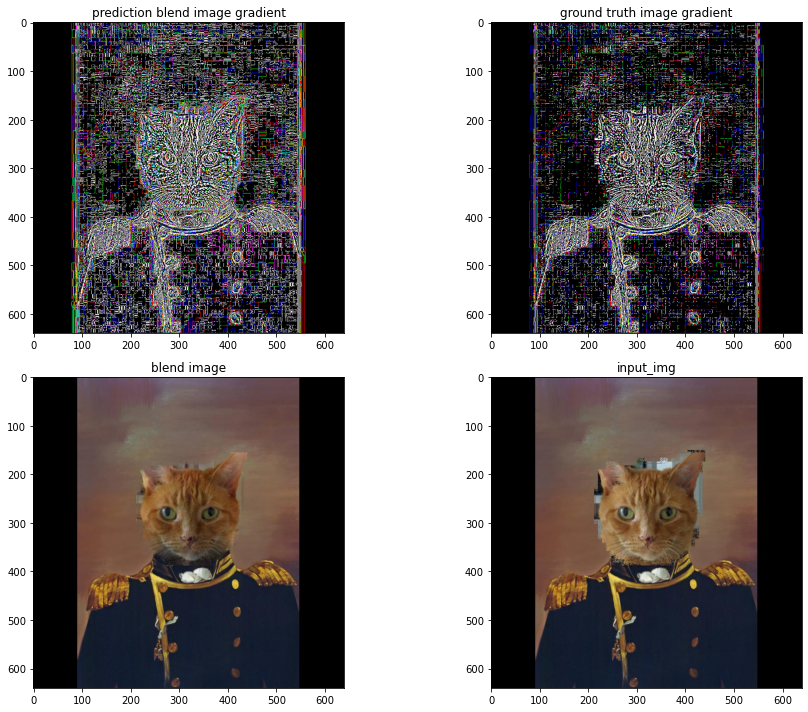

In [18]:
with torch.no_grad():
    blend_img = (input_img * mask + target * (1 - mask))
    blend_gradients = torch.stack(get_blending_gradients(blend_img, device=device), dim=2).squeeze(0)
    plots_multiple_tensor_image(np.asarray(_pil_image(blend_gradients)),
                                np.asarray(_pil_image(gt_gradients)),
                                np.asarray(_pil_image(blend_img)),
                                np.asarray(_pil_image(naive_copy)),
                                title_name=["prediction blend image gradient",
                                           "ground truth image gradient",
                                           "blend image",
                                           "input_img"], normalize=opt.normalize, ncols = 2)

# Comparation with naive copy

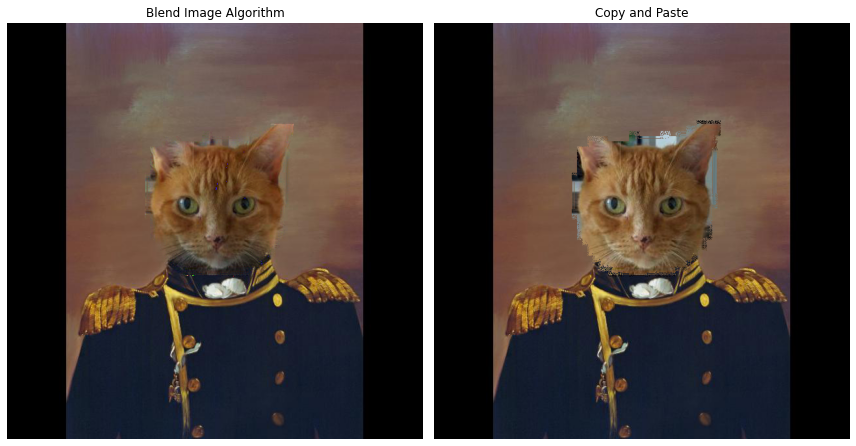

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(12, 12), tight_layout=True)

with torch.no_grad():
    ax[0].set_axis_off()
    ax[0].set_title("Blend Image Algorithm")
    ax[0].imshow(np.asarray(_pil_image(blend_img)))
    
    ax[1].set_axis_off()
    ax[1].set_title("Copy and Paste")
    ax[1].imshow(np.asarray(_pil_image(naive_copy)))
    
fig.savefig("results/comparation.jpg")